In [1]:
# After running this cell, check http://localhost:4040 (spark dashboard)
# and you will see apache spark running.
from pyspark import SparkContext 
sc = SparkContext.getOrCreate()

In [2]:
import random
num_samples = 1000000

# This function will be parallelized using spark
def inside(p):     
    x, y = random.random(), random.random()
    return x*x + y*y < 1


count = sc.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)


3.143524


In [28]:
csvreader = spark.read.format("csv").option("header", "true")
df = csvreader.load("data/breadbasket_dms.csv")
df.registerTempTable("breadbasket")
print(type(df))
print(df.printSchema())
print(df.describe().show())
df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Transaction: string (nullable = true)
 |-- Item: string (nullable = true)

None
+-------+----------+--------+------------------+----------------+
|summary|      Date|    Time|       Transaction|            Item|
+-------+----------+--------+------------------+----------------+
|  count|     21293|   21293|             21293|           21293|
|   mean|      null|    null| 4951.990889024562|            null|
| stddev|      null|    null|2787.7583996983885|            null|
|    min|2016-10-30|01:21:05|                 1|      Adjustment|
|    max|2017-04-09|23:38:41|               999|Victorian Sponge|
+-------+----------+--------+------------------+----------------+

None
+----------+--------+-----------+-------------+
|      Date|    Time|Transaction|         Item|
+----------+--------+-----------+-------------+
|2016-10-30|09:58:11|          1|        Bread|
|201

In [9]:
df.head(5)

[Row(Date='2016-10-30', Time='09:58:11', Transaction='1', Item='Bread'),
 Row(Date='2016-10-30', Time='10:05:34', Transaction='2', Item='Scandinavian'),
 Row(Date='2016-10-30', Time='10:05:34', Transaction='2', Item='Scandinavian'),
 Row(Date='2016-10-30', Time='10:07:57', Transaction='3', Item='Hot chocolate'),
 Row(Date='2016-10-30', Time='10:07:57', Transaction='3', Item='Jam')]

In [15]:
spark.sql("SHOW tables").show()

+--------+-----------+-----------+
|database|  tableName|isTemporary|
+--------+-----------+-----------+
|        |breadbasket|       true|
+--------+-----------+-----------+



In [44]:
df2 = spark.sql("""
    SELECT int(Transaction) as ticket_id,
    CONCAT(max(Date)," ", max(Time)) as ticket_date,
    count(Item) as ticket_items,
    collect_list(Item) as items,
    approx_count_distinct(Item) as ticket_numitems
    FROM breadbasket GROUP BY Transaction
    ORDER BY ticket_id 
""")
print(type(df2))
df2.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+---------+-------------------+------------+--------------------+---------------+
|ticket_id|        ticket_date|ticket_items|               items|ticket_numitems|
+---------+-------------------+------------+--------------------+---------------+
|        1|2016-10-30 09:58:11|           1|             [Bread]|              1|
|        2|2016-10-30 10:05:34|           2|[Scandinavian, Sc...|              1|
|        3|2016-10-30 10:07:57|           3|[Hot chocolate, J...|              3|
|        4|2016-10-30 10:08:41|           1|            [Muffin]|              1|
|        5|2016-10-30 10:13:03|           3|[Coffee, Pastry, ...|              3|
|        6|2016-10-30 10:16:55|           3|[Medialuna, Pastr...|              3|
|        7|2016-10-30 10:19:12|           4|[Medialuna, Pastr...|              4|
|        8|2016-10-30 10:20:51|           2|     [Pastry, Bread]|              2|
|        9|2016-10-30 10:21:59|           2|     [Bread,

In [31]:
from pyspark.sql.functions import collect_list, approx_count_distinct

q = df.groupby(df.Transaction).agg(collect_list("Item"), approx_count_distinct("Item"))
q.show()

+-----------+--------------------+---------------------------+
|Transaction|  collect_list(Item)|approx_count_distinct(Item)|
+-----------+--------------------+---------------------------+
|       1090|[Brownie, Coffee,...|                          4|
|       1159|             [Bread]|                          1|
|       1436|      [Coffee, Soup]|                          2|
|       1512|[Hearty & Seasona...|                          3|
|       1572|    [Pastry, Coffee]|                          2|
|       2069|             [Bread]|                          1|
|       2088|      [Scandinavian]|                          1|
|       2136|[Hot chocolate, Tea]|                          2|
|       2162|[Coffee, Tea, Jui...|                          7|
|       2294|         [Tea, NONE]|                          2|
|       2904|[NONE, Sandwich, ...|                          4|
|        296|[Farm House, Scan...|                          2|
|       3210|      [Bread, Bread]|                     

In [48]:
from pyspark.sql.functions import explode
from pyspark.sql import functions as F

#df2.groupBy("ticket_id").pivot("items").agg(F.lit(1)).na.fill(0).show()
m = df2.withColumn("items", explode(df2.items))
m.show()

+---------+-------------------+------------+-------------+---------------+
|ticket_id|        ticket_date|ticket_items|        items|ticket_numitems|
+---------+-------------------+------------+-------------+---------------+
|        1|2016-10-30 09:58:11|           1|        Bread|              1|
|        2|2016-10-30 10:05:34|           2| Scandinavian|              1|
|        2|2016-10-30 10:05:34|           2| Scandinavian|              1|
|        3|2016-10-30 10:07:57|           3|Hot chocolate|              3|
|        3|2016-10-30 10:07:57|           3|          Jam|              3|
|        3|2016-10-30 10:07:57|           3|      Cookies|              3|
|        4|2016-10-30 10:08:41|           1|       Muffin|              1|
|        5|2016-10-30 10:13:03|           3|       Coffee|              3|
|        5|2016-10-30 10:13:03|           3|       Pastry|              3|
|        5|2016-10-30 10:13:03|           3|        Bread|              3|
|        6|2016-10-30 10:

In [51]:
s = m.groupBy("ticket_id").pivot("items").count().na.fill(0)
s.show()

+---------+----------+------------------------+---------+---------------+--------+-----+--------+--------+------------+------+-------------+-----+-------------+------------------+-------+----+-------------+---------------------+------------+------------+---------------+----------+----------------+------+----------------+----+-------+------+------+--------------------------+--------+--------------+----+----------------------+---------+--------------------+-----------+----------+--------+--------+-----+------------+-----------------+-------+--------------+-------------------+-----------------+-----+-------------+---+--------------+-----+----------------+------------+-----------------+---------+--------------+-------------+--------+------+------+----------------+----+---------+--------------+--------+------+------------------+-------+-------+--------+-----------------------------+--------+-----+--------+------------+-----+--------+---------+----+--------------+------+------------+-------+

In [55]:
s.select(s.columns[:5]).show()

+---------+----------+------------------------+---------+---------------+
|ticket_id|Adjustment|Afternoon with the baker|Alfajores|Argentina Night|
+---------+----------+------------------------+---------+---------------+
|        1|         0|                       0|        0|              0|
|        2|         0|                       0|        0|              0|
|        3|         0|                       0|        0|              0|
|        4|         0|                       0|        0|              0|
|        5|         0|                       0|        0|              0|
|        6|         0|                       0|        0|              0|
|        7|         0|                       0|        0|              0|
|        8|         0|                       0|        0|              0|
|        9|         0|                       0|        0|              0|
|       10|         0|                       0|        0|              0|
|       11|         0|                

In [57]:
s.select(["ticket_id","Scandinavian"]).show()

+---------+------------+
|ticket_id|Scandinavian|
+---------+------------+
|        1|           0|
|        2|           2|
|        3|           0|
|        4|           0|
|        5|           0|
|        6|           0|
|        7|           0|
|        8|           0|
|        9|           0|
|       10|           1|
|       11|           0|
|       12|           0|
|       13|           0|
|       14|           0|
|       15|           1|
|       16|           0|
|       17|           0|
|       18|           0|
|       19|           0|
|       20|           0|
+---------+------------+
only showing top 20 rows



In [61]:
s.filter("Scandinavian>=2").select("ticket_id").show()

+---------+
|ticket_id|
+---------+
|        2|
|     6756|
+---------+



In [63]:
w = s.toPandas()

In [64]:
w.head()

,ticket_id,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
w.drop(columns=["ticket_id"], inplace=True)
w.shape

(9531, 95)

In [71]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
values = pca_model.fit_transform(w)

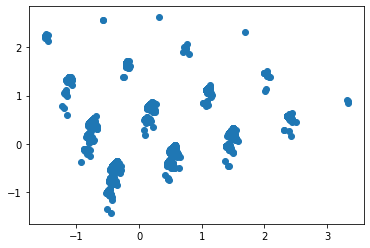

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(values[:,0],values[:,1])
